# **How can macroeconomics data be used for FX rate forecasting?**

The data provided by Dan has both the release value, and what the market expectations are for that date. The date format is in YYYYMMDD. There is also a description of what the economic indicator is.

## **Initial assumptions and ideas**
Dan assumes that the size of the relative surprise in the release will have a bigger short term effect on the exchange rate. But he also thinks that it is important to forecast a slightly longer time period than 5 min in order to see if they have a longer term effect.

To analyze the impact of economic indicators on exchange rates, I did pre-processing and statistical analysis. The idea is using the preprocessed data for time series forecasting using ARIMA or sophsticated ML model.


In [4]:
!pip install -q openai langchain pyvis gradio transformers newsapi-python darts

### **Using surprise factor for time series forecasting**
In macroeconomics, the surprise factor refers to the difference between the actual economic data released and the market's expectations for that data. It is a measure of how much the actual outcome deviates from the consensus forecast. When an economic indicator is released, analysts and market participants have a median forecast based on their analysis and models. If the actual release value is higher than the forecast, it's considered a positive surprise, and if it's lower, it's a negative surprise. This surprise factor can have significant effects on financial markets as it may lead to immediate adjustments in asset prices. For example, if the actual GDP growth rate is higher than expected, it might lead to an appreciation of the country's currency because it suggests a stronger economy and potential for higher interest rates in the future.

Conversely, if inflation is higher than expected, it could lead to a depreciation of the currency due to fears of economic overheating and loss of purchasing power. Therefore, the surprise factor is particularly important for time series forecasting tasks like predicting currency exchange rates because it represents new information that was not previously priced into the market. When incorporated into econometric models, surprise factors can improve the accuracy of forecasts by accounting for the impact of new economic information on future market movements.

In [ ]:
# @title
# Calculate the surprise factor as the difference between release value and market expectation
eur_macro_df['Surprise'] = eur_macro_df['ACTUAL_RELEASE'] - eur_macro_df['BN_SURVEY_MEDIAN']
# There are NULLS in the data. That's why I considered more recent data, e.g., 2010 to 2024.
recent_eur_macro_df = eur_macro_df[(eur_macro_df['ECO_RELEASE_DT'] > '2010-01-01') & (eur_macro_df['ECO_RELEASE_DT'] < '2024-04-01')]
recent_eur_macro_df[['Index', 'ECO_RELEASE_DT', 'Surprise']].head()

## **GDP and inflation rates**
Both the release value and market expectation are specific figures related to various economic indicators that are released periodically, such as employment numbers, consumer price index, manufacturing data, etc. These figures are keenly watched by market participants as they provide insight into the economic health of a country.

- **Gross Domestic Product (GDP)**: GDP is a broad measure of a nation's overall economic activity and is the most widely used indicator of economic performance.
- **Inflation rate**: inflation is the rate at which the general level of prices for goods and services is rising, and subsequently, purchasing power is falling.

The release values, market expectations, GDP, and inflation rates are essential components of macroeconomic analysis. They are used to gauge the current state of an economy and to forecast future performance. When combined, they can provide a comprehensive picture of economic conditions and help in making more informed predictions about economic trends, including currency exchange rates.

### **Harmonized index of consumer prices (HICP) for inflation rates**
Several economic indicators are relevant for analyzing inflation in the Eurozone, and they help in understanding the different factors that contribute to inflationary pressures. Here are some key indicators:

1. **Consumer Price Index (CPI)**: Measures changes in the price level of a market basket of consumer goods and services purchased by households.
2. **Producer Price Index (PPI)**: Indicates the average changes in prices received by domestic producers for their output and is a leading indicator of consumer price inflation.
3. **Wage Growth**: Higher wages can lead to increased spending and demand, which can push prices up.
4. **Unemployment Rate**: Lower unemployment generally leads to higher wages, which can contribute to inflation.
5. **Money Supply (M3)**: The amount of money circulating in the economy can affect inflation, with a larger money supply potentially leading to higher prices.
6. **Economic Growth (GDP)**: Strong economic growth can lead to inflation if it outpaces the economy's ability to produce goods and services.
7. **Commodity Prices**: Increases in the prices of commodities, such as oil or metals, can lead to higher production costs and consumer prices.
8. **Balance of Trade**: A trade deficit can lead to depreciation of the currency, which can increase the price of imports and contribute to inflation.
9. **Interest Rates**: Set by the European Central Bank (ECB), interest rates can influence inflation by affecting borrowing costs and economic activity.
10. **Exchange Rates**: The strength of the euro against other currencies can affect import prices and, consequently, inflation.

These indicators are often used in conjunction with the Harmonized Index of Consumer Prices (HICP) to provide a comprehensive picture of inflationary trends in the Eurozone. Inflation rates measured HICPs are comparable measures of changes in consumer prices. They are compiled on the basis of harmonised rules and standards, particularly in terms of the coverage of goods and services and the treatment of price observations. The ECB uses the HICP inflation rates for assessing price stability in the euro area.

### **Notes for Dan**
The indexes you mentioned (e.g., GRCP20YY, GRIORTMM, and EURR002W) are likely tied to specific economic indicators within the Eurozone. These could be related to various sectors or aspects of the economy, like consumer confidence, manufacturing activity, or retail sales.

But when it comes to GDP, it is indeed a measure of the economic output of a specific country. However, for an economic zone like the Eurozone, which comprises multiple countries using the euro (EUR) as their currency, analysts often look at the aggregate GDP of the entire zone. This aggregate GDP is a sum of the GDPs of all member countries and provides a broader view of the economic performance of the zone as a whole. To link the economic releases, market expectations, and surprise data with other macroeconomic factors like GDP, it makes sense to use the aggregated GDP of the Eurozone.

Similarly, for inflation rates, we should use the harmonized index of consumer prices (HICP). I did some research and feels like HICP can be a measure to compare and combine inflation rates across different countries in the EU.

In [ ]:
# @title
EUR_HICP_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Harmonized_Index_of_Consumer_Prices_HICP_EUR.csv'
eur_hicps_df = pd.read_csv(EUR_HICP_FILE_PATH)

eur_hicps_df = eur_hicps_df[['DATE', 'HICP']]

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_hicps_df['DATE'] = eur_hicps_df['DATE'].apply(format_me)
eur_hicps_df['DATE'] = pd.to_datetime(eur_hicps_df['DATE'], format='%Y%m%d')
eur_hicps_df = eur_hicps_df[(eur_hicps_df['DATE'] > '2010-01-01') & (eur_hicps_df['DATE'] < '2024-04-01')]
eur_hicps_df.head()

In [ ]:
# @title
# Sort the dataframes by the date columns
recent_eur_macro_df = recent_eur_macro_df.sort_values('ECO_RELEASE_DT')
eur_hicps_df = eur_hicps_df.sort_values('DATE')

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
merged_df = pd.merge_asof(recent_eur_macro_df, eur_hicps_df, left_on='ECO_RELEASE_DT', right_on='DATE', direction='forward')
merged_df.head()

### **GDP**
When it comes to GDP, it is indeed a measure of the economic output of a specific country. However, for an economic zone like the Eurozone, which comprises multiple countries using the euro (EUR) as their currency, analysts often look at the aggregate GDP of the entire zone. This aggregate GDP is a sum of the GDPs of all member countries and provides a broader view of the economic performance of the zone as a whole. To link the economic releases, market expectations, and surprise data with other macroeconomic factors like GDP, it makes sense to use the aggregated GDP of the Eurozone.

In [ ]:
# @title
EUR_Agg_GDP_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Aggregated_GDP_Composition_EUR.csv'
eur_agg_gdp_df = pd.read_csv(EUR_Agg_GDP_FILE_PATH)

eur_agg_gdp_df.columns = ['GDP_Date', 'GDP_Period', 'Aggregated_GDP']

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_agg_gdp_df['GDP_Date'] = eur_agg_gdp_df['GDP_Date'].apply(format_me)
eur_agg_gdp_df['GDP_Date'] = pd.to_datetime(eur_agg_gdp_df['GDP_Date'], format='%Y%m%d')
eur_agg_gdp_df = eur_agg_gdp_df[(eur_agg_gdp_df['GDP_Date'] > '2010-01-01') & (eur_agg_gdp_df['GDP_Date'] < '2024-04-01')]
eur_agg_gdp_df.head()

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
eur_agg_gdp_df = eur_agg_gdp_df.sort_values('GDP_Date')
merged_df = pd.merge_asof(merged_df, eur_agg_gdp_df, left_on='ECO_RELEASE_DT', right_on='GDP_Date', direction='forward')
merged_df.head()

In [ ]:
# @title
EUR_Interest_Rate_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Interest_Rates_EUR.csv'
eur_interest_rate_df = pd.read_csv(EUR_Interest_Rate_FILE_PATH)

eur_interest_rate_df.columns = ['Interest_rate_Date', 'Interest_rate_Period', 'Interest_rate']

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_interest_rate_df['Interest_rate_Date'] = eur_interest_rate_df['Interest_rate_Date'].apply(format_me)
eur_interest_rate_df['Interest_rate_Date'] = pd.to_datetime(eur_interest_rate_df['Interest_rate_Date'], format='%Y%m%d')
eur_interest_rate_df = eur_interest_rate_df[(eur_interest_rate_df['Interest_rate_Date'] > '2010-01-01') & (eur_interest_rate_df['Interest_rate_Date'] < '2024-04-01')]

eur_interest_rate_df = eur_interest_rate_df.sort_values('Interest_rate_Date')

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
merged_df = pd.merge_asof(merged_df, eur_interest_rate_df, left_on='ECO_RELEASE_DT', right_on='Interest_rate_Date', direction='forward')

merged_df.head()

In [ ]:
merged_df.tail()

In [ ]:
# @title
EUR_Interest_Rate_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_ECB/Interest_Rates_EUR.csv'
eur_interest_rate_df = pd.read_csv(EUR_Interest_Rate_FILE_PATH)

eur_interest_rate_df.columns = ['Interest_rate_Date', 'Period', 'Interest_rate']

# Convert the date format from YYYYMMDD to a datetime object
def format_me(date):
  return date.replace('-','')

eur_interest_rate_df['Interest_rate_Date'] = eur_interest_rate_df['Interest_rate_Date'].apply(format_me)
eur_interest_rate_df['Interest_rate_Date'] = pd.to_datetime(eur_interest_rate_df['Interest_rate_Date'], format='%Y%m%d')
eur_interest_rate_df = eur_interest_rate_df[(eur_interest_rate_df['Interest_rate_Date'] > '2010-01-01') & (eur_interest_rate_df['Interest_rate_Date'] < '2024-04-01')]

eur_interest_rate_df = eur_interest_rate_df.sort_values('Interest_rate_Date')

# Merge asof with the condition that 'ECO_RELEASE_DT' is earlier than or within 'DATE'
merged_df = pd.merge_asof(merged_df, eur_interest_rate_df, left_on='ECO_RELEASE_DT', right_on='Interest_rate_Date', direction='forward')

merged_df.head()

To analyze the impact of economic indicators on exchange rates and forecast potential longer-term effects, you can use Python to perform statistical analysis. Below is a sample code snippet that demonstrates how to load the data, calculate the surprise factor, and perform a simple linear regression analysis to understand the relationship between the surprise factor and exchange rate changes.


In [ ]:
# @title
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
import numpy as np

# Load your spreadsheet data into a DataFrame
# Replace 'your_spreadsheet.csv' with the actual file path
df = pd.read_csv('your_spreadsheet.csv')

# Convert the date format from YYYYMMDD to a datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Calculate the surprise factor as the difference between release value and market expectation
df['Surprise'] = df['Release_Value'] - df['Market_Expectation']

# Assume 'Exchange_Rate_Change' is a column in your DataFrame representing the change in exchange rate
# Prepare the features (X) and the target (y)
X = df[['Surprise']]  # Features (2D array for sklearn)
y = df['Exchange_Rate_Change']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the Exchange Rate Change
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Use the model to forecast future exchange rate changes
# For example, if you have a new surprise factor value
new_surprise_value = np.array([[5]])  # Replace 5 with your actual surprise factor value
predicted_change = model.predict(new_surprise_value)
print(f"Predicted Exchange Rate Change: {predicted_change[0]}")

- 1. Can this be modelled as a time series forecasting with ARIMA or transformer based forecasting algorithm?

- 2. Is it possible to forecast the directionality, e.g., the exchange rate will go up or down?

Time Series Forecasting with ARIMA or Transformer-Based Algorithms:
Yes, the problem can indeed be modeled as a time series forecasting issue. ARIMA (AutoRegressive Integrated Moving Average) is a popular statistical method used for time series forecasting that can capture various patterns in temporal data. However, ARIMA requires the data to be stationary, so you may need to preprocess your data to stabilize the mean and variance over time.

Transformer-based algorithms, like the ones used in machine learning models such as BERT or GPT, can also be applied to time series forecasting. These models can potentially capture complex patterns and long-term dependencies in the data. They are particularly useful when you have a large amount of high-dimensional time series data.

Here's a simple example of how you might set up an ARIMA model for time series forecasting:

In [ ]:
# @title
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Assuming 'df' is your DataFrame and it includes a 'Date' and 'Exchange_Rate' column
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date', inplace=True)

# Fit the ARIMA model
model = ARIMA(df['Exchange_Rate'], order=(1, 1, 1))  # Example order, adjust based on your data
arima_result = model.fit()

# Forecast future values
forecast = arima_result.get_forecast(steps=5)  # Adjust steps for your desired forecast length
forecast_index = pd.date_range(start=df.index[-1], periods=5, freq='D')  # Adjust frequency as needed
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecast'])

print(forecast_df)

### **Forecasting directionality**

Forecasting the directionality of exchange rates (whether they will go up or down) is a common goal in financial time series analysis. One approach is to use classification models that predict whether the change will be positive or negative. Another approach is to look at the sign of the forecasted values from a regression or time series model.

For instance, if we're using a regression model, we can interpret positive predicted values as an indication that the exchange rate is expected to increase, and negative values as a decrease. Similarly, with time series models, we can compare the forecasted value with the last known value to determine the direction of the change.

Here's an example of how you might predict directionality using the sign of the forecasted changes:

In [41]:
# @title
# Continuing from the ARIMA example above
# Determine the direction of the change
last_known_rate = df['Exchange_Rate'].iloc[-1]
forecast_df['Direction'] = forecast_df['Forecast'].apply(lambda x: 'Up' if x > last_known_rate else 'Down')

print(forecast_df[['Forecast', 'Direction']])

NameError: name 'df' is not defined

In this code snippet, the Direction column is added to the forecast DataFrame, indicating whether the forecasted exchange rate is expected to go up or down compared to the last known rate.

Remember, financial markets are influenced by a multitude of factors, and models can only capture so much. It's important to combine model forecasts with domain expertise and other market analyses. Additionally, the performance of these models should be validated using historical data to assess their predictive power.

## New start

In [ ]:
# @title

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from transformers import TimeSeriesTransformer

# Load and combine your data
# df = pd.read_csv('your_combined_data.csv')

# Feature Engineering
# Assume 'df' is your combined DataFrame with all the necessary features

# Data Normalization
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Model Building
# Define your transformer model
model = TimeSeriesTransformer(
input_size=1,  # Number of features
output_size=1,  # Forecast horizon
num_layers=2,  # Number of transformer layers
d_model=64,  # Dimension of the model
num_heads=8,  # Number of heads in the multi-head attention mechanism
dropout=0.1,  # Dropout rate
activation='relu'  # Activation function
)

# Training
# model.fit(df_scaled, epochs=10, batch_size=32)

# Evaluation
# model.evaluate(validation_data)

# Forecasting
# predictions = model.predict(future_data_scaled)

In [1]:
from google.colab import drive
# Read the data into a pandas DataFrame
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40

In [3]:
from darts import TimeSeries
from darts.models import Prophet
from darts import TimeSeries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from darts.models import ExponentialSmoothing
from darts.metrics import mape
from darts.models import NaiveDrift

We create a dataset where the features (input variables) are aligned with the target variable (EUR/USD) in a way that reflects the true economic relationships and timing of effects. Testing different alignments and feature sets can help determine the best approach for your model.  Additionally, for combining your investment index data, you might find methods like window-based summary, time-series heuristics, and time-series encoding useful. These techniques can help you align and aggregate your time series data with other tabular data for prediction purposes.

In [4]:
EUR_INDEX_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Macro_Data_FX_Rate_EUR.csv'
USD_INDEX_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Macro_Data_FX_Rate_USD.csv'
GBP_INDEX_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Macro_Data_FX_Rate_GBP.csv'
CHF_INDEX_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Macro_Data_FX_Rate_CHF.csv'
DXY_INDEX_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Macro_Data_FX_Rate_DXY.csv'
FX_RATE_MACRO_FILE_PATH = '/content/drive/My Drive/ADA_freelance/FX_rates_data/From_Dan/FX_Rates.csv'

# **Pre-processing**

Thanks. I also have the macro Index for Eurozone, US, GBP, and CHF.So, question is how can I use these along with Indexes for the Euro, UK, and Swiss economies? Assuming I'll keep using the GBP/USD and CHF/USD as other two input variables, whereas EUR/USD will be my target column for my time series forecasting model. Please give sample code snipped for that. To incorporate the macroeconomic indexes for the US, Eurozone, UK, and Swiss economies into your time series forecasting model, you can follow these steps:

1. **Data Preparation**: Merge the macroeconomic index data with your FX rate data on the date column to create a unified dataset. Ensure that all data is aligned by date and that there are no missing values.
2. **Feature Engineering**: Calculate additional features that may be relevant for your model, such as percentage changes or differences between actual releases and survey medians (surprises).
3. **Model Input**: Use the FX rates (GBP/USD, CHF/USD) and the engineered features from the macroeconomic indexes as input variables (features), with EUR/USD as the target variable (label).

In [5]:
# Function to convert dates with mixed formats
def convert_dates(date_str):
  try:
    # First, try parsing the 'YYYYMMDD' format
    return pd.to_datetime(date_str, format='%Y%m%d', errors='coerce')
  except ValueError:
    # If there's a ValueError, try parsing the 'M/DD/YYYY' format
    return pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce')

# Function to convert dates with mixed formats
def convert_dates_for_aux(date_str):
  # If there's a ValueError, try parsing the 'M/DD/YYYY' format
  return pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce')

In [6]:
def process_main_indexes(INDEX_MACRO_FILE_PATH, recent_data_only):
  # Assuming EUR_INDEX_MACRO_FILE_PATH is defined and points to your CSV file
  df = pd.read_csv(INDEX_MACRO_FILE_PATH, header=[0, 1], dtype={'ECO_RELEASE_DT': str})

  # Create a list of tuples containing the index name and its corresponding columns
  index_columns = [(col[0], col[1]) for col in df.columns]

  # Prepare a list to hold the processed data
  processed_data = []
  num_index_col = 3

  # Iterate over the rows in the dataframe
  for _, row in df.iterrows():
    # Iterate over the index_columns list in steps of 3
    for i in range(0, len(index_columns), num_index_col):
      # Extract the index name and the corresponding ECO_RELEASE_DT, ACTUAL_RELEASE, BN_SURVEY_MEDIAN
      index_name, _ = index_columns[i]
      eco_release_dt = row[index_columns[i]]
      actual_release = row[index_columns[i+1]]
      bn_survey_median = row[index_columns[i+2]]

      # Append the data to the processed_data list
      processed_data.append({
      'Index': index_name,
      'ECO_RELEASE_DT': eco_release_dt,
      'ACTUAL_RELEASE': actual_release,
      'BN_SURVEY_MEDIAN': bn_survey_median
      })

  # Create a new dataframe from the processed data
  df = pd.DataFrame(processed_data)

  # Apply the function to the ECO_RELEASE_DT column
  df['ECO_RELEASE_DT'] = df['ECO_RELEASE_DT'].apply(convert_dates)

  if recent_data_only:
      df = df[(df['ECO_RELEASE_DT'] > '2010-01-01') & (df['ECO_RELEASE_DT'] < '2024-04-01')]

  return df

In [7]:
def process_aux_indexes(INDEX_MACRO_FILE_PATH, recent_data_only):
  # Assuming EUR_INDEX_MACRO_FILE_PATH is defined and points to your CSV file
  df = pd.read_csv(INDEX_MACRO_FILE_PATH)

  # Apply the function to the ECO_RELEASE_DT column
  df['Date'] = df['Date'].apply(convert_dates_for_aux)

  if recent_data_only:
    df = df[(df['Date'] > '2010-01-01') & (df['Date'] < '2024-04-01')]

  return df

This code snippet assumes that you have the FX rate data and macroeconomic index data ready to be loaded into pandas DataFrames. The merging process aligns the data by date, and the feature engineering step creates a new feature representing the surprise as a percentage.

In [8]:
def calculate_surprise_factor(df, recent_data_only):
  # Calculate the surprise factor as the difference between release value and market expectation
  df['Surprise'] = df['ACTUAL_RELEASE'] - df['BN_SURVEY_MEDIAN']

  # Feature engineering: calculate surprises as a percentage of the median
  df['Surprise_pct'] = df['Surprise'] / df['BN_SURVEY_MEDIAN']

  if recent_data_only:
    df = df[(df['ECO_RELEASE_DT'] > '2010-01-01') & (df['ECO_RELEASE_DT'] < '2024-04-01')]

  # # There are NULLS in the data. That's why I considered more recent data, e.g., 2010 to 2024.
  # df = df[(eur_macro_df['ECO_RELEASE_DT'] > '2010-01-01') & (df['ECO_RELEASE_DT'] < '2024-04-01')]

  return df[['Index', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'BN_SURVEY_MEDIAN', 'Surprise', 'Surprise_pct']]

def process_fx_rate_data(INDEX_MACRO_FILE_PATH, recent_data_only):
  # Assuming EUR_INDEX_MACRO_FILE_PATH is defined and points to your CSV file
  df = pd.read_csv(INDEX_MACRO_FILE_PATH)

  # Assuming 'df' is your DataFrame, define a mapping of old column names to new column names with a slash
  column_mapping = {
  'GBPUSD': 'GBP/USD',
  'EURUSD': 'EUR/USD',
  'USDCHF': 'USD/CHF',
  'USDGBP': 'USD/GBP',
  'USDEUR': 'USD/EUR',
  'CHFUSD': 'CHF/USD'
  }

  # Rename the columns using the mapping
  df.rename(columns=column_mapping, inplace=True)

  # Assuming 'df' is your DataFrame, strip leading/trailing spaces and replace multiple spaces with a single space
  df.columns = df.columns.str.strip().str.replace(r'\s+', ' ', regex=True)

  # Apply the function to the ECO_RELEASE_DT column
  df['Date'] = df['Date'].apply(convert_dates_for_aux)

  if recent_data_only:
    df = df[(df['Date'] > '2010-01-01') & (df['Date'] < '2024-04-01')]

  return df

In [9]:
eur_macro_df = process_main_indexes(EUR_INDEX_MACRO_FILE_PATH, True)
usd_macro_df = process_main_indexes(USD_INDEX_MACRO_FILE_PATH, True)
gbp_macro_df = process_main_indexes(GBP_INDEX_MACRO_FILE_PATH, True)
chf_macro_df = process_main_indexes(CHF_INDEX_MACRO_FILE_PATH, True)
dxy_macro_df = process_aux_indexes(DXY_INDEX_MACRO_FILE_PATH, True)

eur_macro_df_with_sf = calculate_surprise_factor(eur_macro_df, True)
usd_macro_df_with_sf = calculate_surprise_factor(usd_macro_df, True)
gbp_macro_df_with_sf = calculate_surprise_factor(gbp_macro_df, True)
chf_macro_df_with_sf = calculate_surprise_factor(chf_macro_df, True)
fx_rate_df  = process_fx_rate_data(FX_RATE_MACRO_FILE_PATH, True)

Here, one issue is that the date in exchange rate pairs and those macroeconomic indexes are not mapped because macroeconomics index often relate the data by weekly, quarterly, monthly, or yearly. So, how I can do above steps keeping these data/time mismatch issue?

Handling mismatches in data frequency is a common challenge in time series analysis, especially when combining daily financial data with less frequently reported macroeconomic indicators. Here's a strategy to align your datasets:

1. **Resampling**: Convert the higher frequency data (daily FX rates) to match the lower frequency of the macroeconomic indexes using resampling techniques. For instance, you can aggregate daily rates into weekly or monthly averages.
2. **Lagging**: Introduce lags for macroeconomic indicators to account for  time it takes for economic policies & changes to affect the market.
3. **Interpolation**: If necessary, interpolate missing values in the macroeconomic data to match the daily frequency of the FX rates.
4. **Feature Engineering**: Create features that capture the time-varying effects of macroeconomic indicators on FX rates, such as moving averages or changes over time.

In [10]:
def get_interpolated_macro_df(df, date_col, index_name):
  # Convert the date column to datetime
  df[date_col] = pd.to_datetime(df[date_col])
  # Set the date column as the index and remove duplicates
  df.set_index(date_col, inplace=True)
  df = df[~df.index.duplicated(keep='first')]

  # Create a date range for reindexing
  date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
  # Reindex the DataFrame to fill in missing dates
  df = df.reindex(date_range)

  # Fill missing values in the 'Index' column using forward fill
  df[index_name] = df[index_name].ffill()

  return df

def resample_exchange_rate(fx_rate):
  # Resample FX rates to weekly/monthly averages if needed
  fx_rate.set_index('Date', inplace=True)
  daily = fx_rate.resample('D').mean()  # Weekly average
  weekly = fx_rate.resample('W').mean()  # Weekly average
  monthly = fx_rate.resample('M').mean()  # Monthly average

  return daily, weekly, monthly

def get_macro_and_fx_rate_interpolated(macro_with_sf, fx_weekly_data, target_pair):
  # Lag macroeconomic indicators if needed
  macro_df_interpolated = get_interpolated_macro_df(macro_with_sf, 'ECO_RELEASE_DT', 'Index')
  macro_df_lagged = macro_df_interpolated.shift(1)  # Lag by one period

  # Interpolate missing values in macroeconomic data
  macro_df_interpolated = macro_df_lagged.interpolate(method='time')

  # Merge the datasets
  merged_df = pd.merge_asof(fx_weekly_data, macro_df_interpolated, left_index=True, right_index=True)

  # Feature engineering: create moving averages or changes over time
  merged_df[target_pair + '_1w_MA'] = merged_df[target_pair].rolling(window=1).mean()  # 4-week moving average
  merged_df[target_pair +'_1w_Change'] = merged_df[target_pair].diff(1)  # Change over 4 weeks

  merged_df[target_pair + '_4w_MA'] = merged_df[target_pair].rolling(window=4).mean()  # 4-week moving average
  merged_df[target_pair + '_4w_Change'] = merged_df[target_pair].diff(4)  # Change over 4 weeks

  surprise_name = 'Surprise_' + target_pair.split('/')[0]
  surprise_pct_name = 'Surprise_pct_' + target_pair.split('/')[0]

  index_name = 'Index_' + target_pair.split('/')[0]
  release_name = 'ACTUAL_RELEASE_' + target_pair.split('/')[0]
  survey_name = 'BN_SURVEY_MEDIAN_' + target_pair.split('/')[0]

  merged_df.rename(columns={'Surprise': surprise_name, 'Surprise_pct': surprise_pct_name, 'Index': index_name, 'ACTUAL_RELEASE': release_name, 'BN_SURVEY_MEDIAN': survey_name}, inplace=True)

  return merged_df

In [11]:
# Resample FX rates to weekly/monthly averages if needed
fx_rate_df = fx_rate_df.drop(columns=['USD/CHF', 'USD/GBP', 'USD/EUR'])
fx_rate_df_eur, fx_rate_df_gbp, fx_rate_df_chf = fx_rate_df[['Date', 'EUR/USD']], fx_rate_df[['Date', 'GBP/USD']], fx_rate_df[['Date', 'CHF/USD']]

fx_daily_eur, fx_weekly_eur, fx_monthly_eur = resample_exchange_rate(fx_rate_df_eur)
fx_daily_gbp, fx_weekly_gbp, fx_monthly_gbp = resample_exchange_rate(fx_rate_df_gbp)
fx_daily_chf, fx_weekly_chf, fx_monthly_chf = resample_exchange_rate(fx_rate_df_chf)

# target_economies = [eur_macro_df_with_sf, usd_macro_df_with_sf, gbp_macro_df_with_sf, chf_macro_df_with_sf]

In [12]:
eur_macro_and_fx_rate_interpolated = get_macro_and_fx_rate_interpolated(eur_macro_df_with_sf, fx_weekly_eur, 'EUR/USD')
gbp_macro_and_fx_rate_interpolated = get_macro_and_fx_rate_interpolated(gbp_macro_df_with_sf, fx_weekly_gbp, 'GBP/USD')
chf_macro_and_fx_rate_interpolated = get_macro_and_fx_rate_interpolated(chf_macro_df_with_sf, fx_weekly_chf, 'CHF/USD')

In [13]:
usd_macro_and_fx_rate_interpolated = get_interpolated_macro_df(usd_macro_df_with_sf, 'ECO_RELEASE_DT', 'Index')
usd_macro_df_lagged = usd_macro_and_fx_rate_interpolated.shift(1)  # Lag by one period

# Interpolate missing values in macroeconomic data
usd_macro_df_interpolated = usd_macro_df_lagged.interpolate(method='time')

surprise_name = 'Surprise_USD'
surprise_pct_name = 'Surprise_pct_USD'

index_name = 'Index_USD'
release_name = 'ACTUAL_RELEASE_USD'
survey_name = 'BN_SURVEY_MEDIAN_USD'

usd_macro_df_interpolated.rename(columns={'Surprise': surprise_name, 'Surprise_pct': surprise_pct_name, 'Index': index_name, 'ACTUAL_RELEASE': release_name, 'BN_SURVEY_MEDIAN': survey_name}, inplace=True)

In [14]:
usd_macro_df_interpolated.index.name = 'Date'

In [15]:
# eur_macro_and_fx_rate_interpolated = eur_macro_and_fx_rate_interpolated.drop(columns=['ACTUAL_RELEASE', 'USD/GBP', 'USD/EUR'])
# gbp_macro_and_fx_rate_interpolated = gbp_macro_and_fx_rate_interpolated.drop(columns=['ACTUAL_RELEASE', 'USD/GBP', 'USD/EUR'])
# chf_macro_and_fx_rate_interpolated = chf_macro_and_fx_rate_interpolated.drop(columns=['ACTUAL_RELEASE', 'USD/GBP', 'USD/EUR'])

full_df =  eur_macro_and_fx_rate_interpolated.merge(gbp_macro_and_fx_rate_interpolated, on='Date').merge(chf_macro_and_fx_rate_interpolated, on='Date').merge(usd_macro_df_interpolated, on='Date')

In [94]:
# Use the 'combine_first' method to combine the indices
# full_df['Macro_Index'] = full_df['Index_EUR'].combine_first(full_df['Index_GBP']).combine_first(full_df['Index_CHF']).combine_first(full_df['Index_USD'])

In [16]:
full_df = full_df.iloc[5:,:]

In [19]:
full_df.head()

,EUR/USD,Index_EUR,ACTUAL_RELEASE_EUR,BN_SURVEY_MEDIAN_EUR,Surprise_EUR,Surprise_pct_EUR,EUR/USD_1w_MA,EUR/USD_1w_Change,EUR/USD_4w_MA,EUR/USD_4w_Change,...,Surprise_pct_CHF,CHF/USD_1w_MA,CHF/USD_1w_Change,CHF/USD_4w_MA,CHF/USD_4w_Change,Index_USD,ACTUAL_RELEASE_USD,BN_SURVEY_MEDIAN_USD,Surprise_USD,Surprise_pct_USD
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-14,1.37016,GRCP20YY Index,0.942857,0.971429,-0.028571,-0.020408,1.37016,-0.01362,1.393895,-0.07774,...,0.225000,0.93444,-0.00716,0.948220,-0.04648,RSTAMOM Index,79.250000,73.166667,6.083333,0.569079
2010-02-21,1.36230,GRCP20YY Index,1.192857,1.271429,-0.078571,-0.056122,1.36230,-0.00786,1.379465,-0.05772,...,0.137500,0.92912,-0.00532,0.939455,-0.03506,CPI CHNG Index,82.833333,76.916667,5.916667,-0.264734
2010-02-28,1.35640,ECCPEMUY Index,12.120000,12.080000,0.040000,0.000709,1.35640,-0.00590,1.368160,-0.04522,...,0.050000,0.92682,-0.00230,0.932995,-0.02584,CONSSENT Index,67.900000,68.566667,-0.666667,-0.010766
2010-03-07,1.36158,GRIORTMM Index,3.560000,1.120000,2.440000,1.946154,1.36158,0.00518,1.362610,-0.02220,...,0.659317,0.93054,0.00372,0.930230,-0.01106,NFP TCH Index,47.000000,20.000000,27.000000,-0.391432
2010-03-14,1.36686,GRCP20YY Index,0.850000,0.750000,0.100000,0.250000,1.36686,0.00528,1.361785,-0.00330,...,-0.063449,0.93562,0.00508,0.930525,0.00118,RSTAMOM Index,0.287500,-0.087500,0.375000,-1.875000


# **Exploratory Analysis**

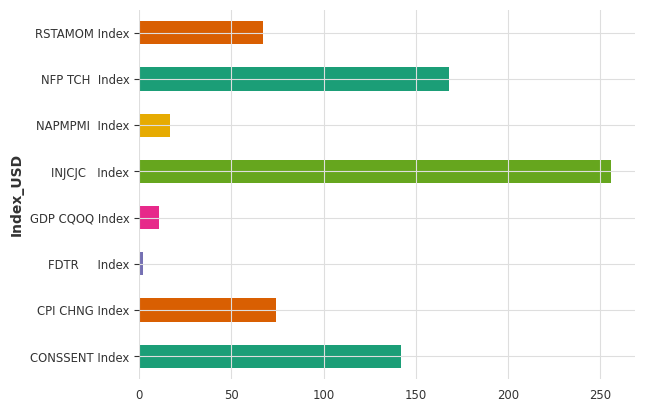

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
full_df.groupby('Index_USD').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

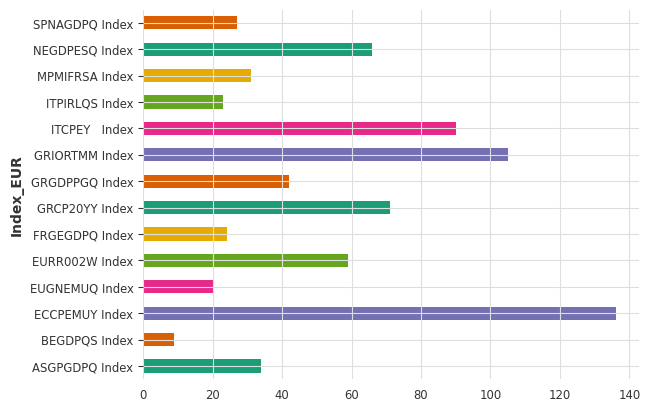

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
full_df.groupby('Index_EUR').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

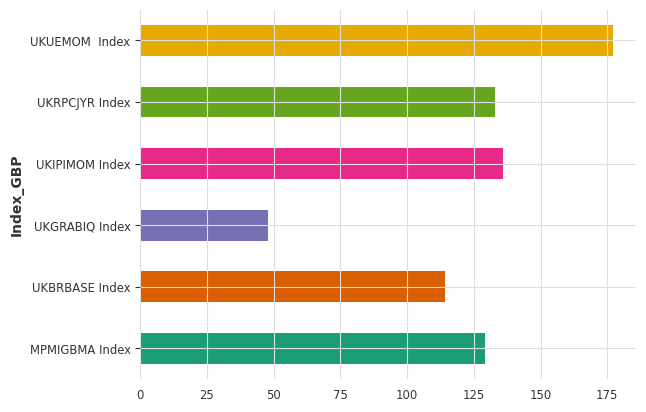

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
full_df.groupby('Index_GBP').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

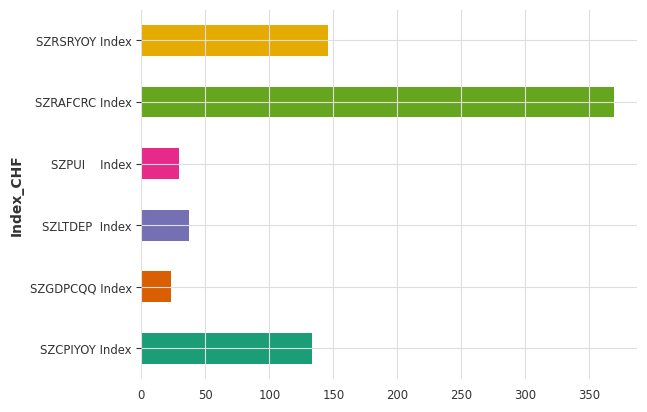

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
full_df.groupby('Index_CHF').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Should we include related parities?**

As we wwant to predict the EUR/USD exchange rate using my time series forecasting model, would it make sense to keep GBP/USD and CHF/USD as input variables (i.e., features) for the models along with other economic indicators like Indexes, whereas the EUR/USD being the target column? It would make sense to include GBP/USD and CHF/USD as input variables in our time series forecasting model for several reasons:

1. **Correlation**: Currency pairs can be correlated with each other. For example, if the GBP/USD rate moves in a certain direction, it might have an impact on the EUR/USD rate due to economic or political events affecting both the Eurozone and the UK.
2. **Market Dynamics**: The foreign exchange market is interconnected. Movements in one currency pair can influence others, especially if they involve major currencies like the GBP and CHF against the USD.
3. **Economic Indicators**: Including economic indicators can provide context to the model about overall economic environment, which can affect exchange rates. Indexes like consumer price index (CPI) and employment rates can be strong predictors of currency movements.
4. **Diversification of Features**: By including multiple currency pairs and economic indicators, you diversify the features that your model can learn from, which can potentially improve its predictive accuracy.

---

However, it's important to be cautious of multicollinearity, where input variables are highly correlated with each other. This can make the model's estimates and predictions less reliable. You might want to check the correlation between your features before including them in the model. Additionally, feature selection techniques can be used to identify which variables are the most important predictors for your target variable, EUR/USD. This can help in simplifying the model and focusing on the most relevant information. We also consider the economic relationship between the currencies and the economic indicators you choose to include, as they should be relevant to the EUR/USD exchange rate forecast. Good luck with your model!

Let's compute the correlation coefficients between GBP/USD and EUR/USD, and between CHF/USD and EUR/USD. A correlation coefficient close to 1 indicates a strong positive correlation, while a coefficient close to -1 indicates a strong negative correlation. A coefficient around 0 indicates no linear relationship.

In [17]:
# Set 'Date' as the index
fx_rate_df.set_index('Date', inplace=True)

# Calculate the correlation matrix
correlation_matrix = fx_rate_df.corr()

# Extract the correlations of GBP/USD and CHF/USD with EUR/USD
eur_usd_gbp_usd_correlation = correlation_matrix.loc['GBP/USD', 'EUR/USD']
eur_usd_chf_usd_correlation = correlation_matrix.loc['CHF/USD', 'EUR/USD']

print(f"Correlation between GBP/USD and EUR/USD: {eur_usd_gbp_usd_correlation}")
print(f"Correlation between CHF/USD and EUR/USD: {eur_usd_chf_usd_correlation}")

Correlation between GBP/USD and EUR/USD: 0.8498661150075326
Correlation between CHF/USD and EUR/USD: 0.2981332167155826


Based on the correlation coefficients you've calculated:

•  GBP/USD and EUR/USD: The correlation coefficient of approximately 0.85 suggests a strong positive correlation. This means that movements in the GBP/USD exchange rate are likely to be mirrored by similar movements in the EUR/USD rate.

•  CHF/USD and EUR/USD: The correlation coefficient of approximately 0.30 indicates a weaker positive correlation, suggesting that the CHF/USD rate does not move in tandem with the EUR/USD rate as closely as the GBP/USD does.

Given this information, whether to include GBP/USD as an input variable in your model depends on the specific goals of your forecasting model and the potential for multicollinearity:

•  If your model's goal is to capture as much relevant information as possible without overfitting, you might consider keeping GBP/USD as a feature because it could provide valuable information about EUR/USD movements.

•  However, if you are concerned about multicollinearity (which can occur when two or more variables are highly correlated and can distort the importance of individual features), you might choose to exclude GBP/USD to simplify the model and potentially improve its generalizability.

It's also worth considering other factors, such as the economic relationship between the UK and the Eurozone, and whether GBP/USD movements provide unique information about EUR/USD that is not captured by other features.

Ultimately, the decision should be informed by further analysis, such as feature importance ranking, and possibly by testing the model's performance with and without the GBP/USD feature. You could use techniques like cross-validation to evaluate the impact of including or excluding GBP/USD on the model's predictive accuracy. If the inclusion of GBP/USD improves the model's performance on out-of-sample data, it may be beneficial to keep it as a feature.

# **Including DXY Index**

In [18]:
# Lag macroeconomic indicators if needed
dxy_macro_df_interpolated = get_interpolated_macro_df(dxy_macro_df, 'Date', 'DXY Index')

In [19]:
dxy_macro_df_interpolated.head()

,DXY Index
2010-01-04,77.525
2010-01-05,77.619
2010-01-06,77.493
2010-01-07,77.913
2010-01-08,77.471


In [20]:
dxy_macro_df_interpolated.index.name = 'Date'
full_df_extended =  full_df.merge(dxy_macro_df_interpolated, on='Date')

In [21]:
full_df_extended.head()

,EUR/USD,Index_EUR,ACTUAL_RELEASE_EUR,BN_SURVEY_MEDIAN_EUR,Surprise_EUR,Surprise_pct_EUR,EUR/USD_1w_MA,EUR/USD_1w_Change,EUR/USD_4w_MA,EUR/USD_4w_Change,...,CHF/USD_1w_MA,CHF/USD_1w_Change,CHF/USD_4w_MA,CHF/USD_4w_Change,Index_USD,ACTUAL_RELEASE_USD,BN_SURVEY_MEDIAN_USD,Surprise_USD,Surprise_pct_USD,DXY Index
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-14,1.37016,GRCP20YY Index,0.942857,0.971429,-0.028571,-0.020408,1.37016,-0.01362,1.393895,-0.07774,...,0.93444,-0.00716,0.948220,-0.04648,RSTAMOM Index,79.250000,73.166667,6.083333,0.569079,80.218
2010-02-21,1.36230,GRCP20YY Index,1.192857,1.271429,-0.078571,-0.056122,1.36230,-0.00786,1.379465,-0.05772,...,0.92912,-0.00532,0.939455,-0.03506,CPI CHNG Index,82.833333,76.916667,5.916667,-0.264734,80.643
2010-02-28,1.35640,ECCPEMUY Index,12.120000,12.080000,0.040000,0.000709,1.35640,-0.00590,1.368160,-0.04522,...,0.92682,-0.00230,0.932995,-0.02584,CONSSENT Index,67.900000,68.566667,-0.666667,-0.010766,80.362
2010-03-07,1.36158,GRIORTMM Index,3.560000,1.120000,2.440000,1.946154,1.36158,0.00518,1.362610,-0.02220,...,0.93054,0.00372,0.930230,-0.01106,NFP TCH Index,47.000000,20.000000,27.000000,-0.391432,80.432
2010-03-14,1.36686,GRCP20YY Index,0.850000,0.750000,0.100000,0.250000,1.36686,0.00528,1.361785,-0.00330,...,0.93562,0.00508,0.930525,0.00118,RSTAMOM Index,0.287500,-0.087500,0.375000,-1.875000,79.833


# **Model training and evaluation**

In [22]:
# This is better, but we are still missing the trend. Fortunately, there is also another naive baseline model capturing the trend, which is called NaiveDrift. This model simply produces linear predictions, with a slope that is determined by the first and last values of the training set:
def train_macroeconomic_fx_rate_forecasting_model_with_drift(train_series):
  # Create and fit the Prophet model
  baseline_model = ExponentialSmoothing()
  baseline_model.fit(train_series)

  drift_model = NaiveDrift()
  drift_model.fit(train_series)

  return baseline_model, drift_model

In [23]:
def macroeconomic_fx_rate_forecasting(df):
  # Convert the aggregated data into a Darts TimeSeries object
  train_series = TimeSeries.from_dataframe(df, time_col='date', value_cols='EUR/USD', fill_missing_dates=True, freq='W')

  training, validation = train_series.split_before(pd.Timestamp("2023-01-01"))

  # Create and fit the Prophet model
  model = ExponentialSmoothing()
  model.fit(training)

  forecast_horizon = 52
  forecast = model.predict(forecast_horizon)

  print(("MAPE = {:.2f}%".format(mape(forecast, validation))))

  # Plot the forecast alongside the actual data
  plt.figure(figsize=(15, 7), dpi=100)
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  ax = plt.gca()  # Get the current Axes instance
  plt.title("MAPE = {:.2f}%".format(mape(forecast, validation)))
  train_series.plot(label="actual")
  forecast.plot(label="forecast")
  plt.legend()

  return model, train_series

In [24]:
def standalone_macroeconomic_fx_rate_forecasting_with_drift(model1, model2, forecast_horizon):
  # Forecast the future liquidity for the next 'n' periods
  forecast = model.predict(n=forecast_horizon, num_samples=100)

  # Extract the quantiles to get the confidence intervals
  lower_quantile = forecast.quantile_timeseries(0.05)
  upper_quantile = forecast.quantile_timeseries(0.95)

  return forecast, lower_quantile, upper_quantile

In [29]:
def macroeconomic_fx_rate_forecasting_with_drift(baseline_model, drift_model, forecast_horizon, train_series, valid_series):
  # Forecast the future liquidity for the next 'n' periods
  forecast_smooting = baseline_model.predict(n=forecast_horizon, num_samples=1000)
  drift_forecast = drift_model.predict(forecast_horizon)
  mean_forecast = forecast_smooting.mean()
  combined_forecast = drift_forecast + mean_forecast - train_series.last_value()

  # Extract the quantiles to get the confidence intervals
  lower_quantile = forecast_smooting.quantile_timeseries(0.05)
  upper_quantile = forecast_smooting.quantile_timeseries(0.95)

  plt.figure(figsize=(15, 7), dpi=100)
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  ax = plt.gca()  # Get the current Axes instance
  train_series.plot()
  combined_forecast.plot(label="combined")
  drift_forecast.plot(label="drift")

  return forecast_smooting, lower_quantile, upper_quantile

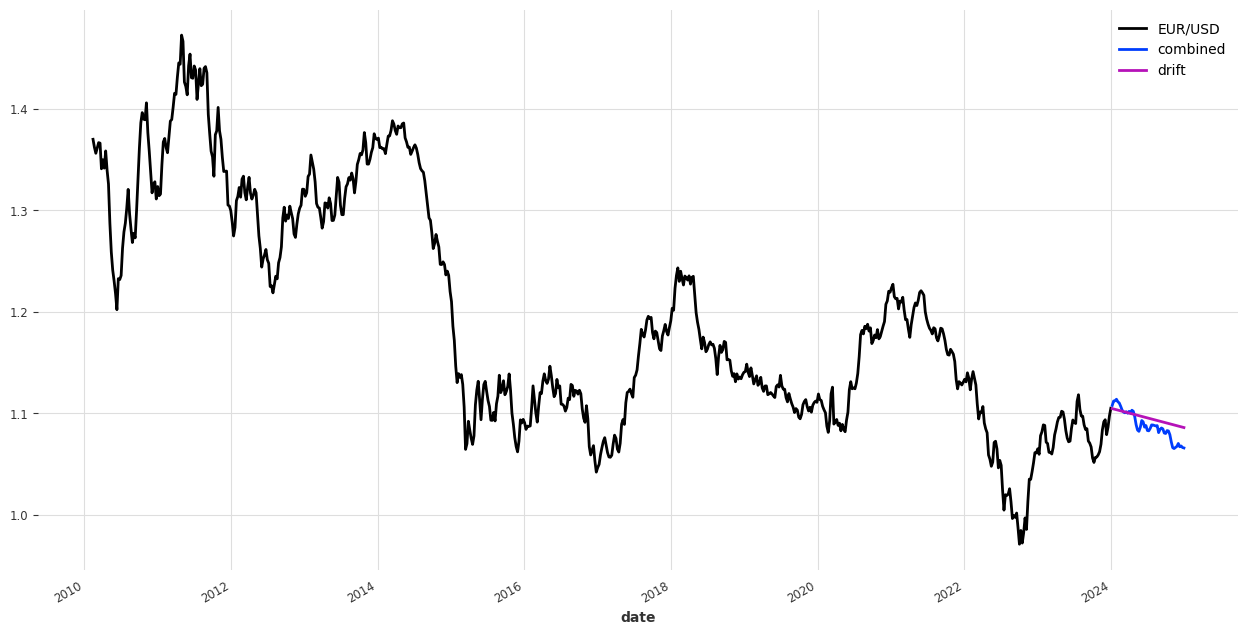

In [35]:
#Fill missing values if necessary, for example with forward fill
full_df_extended.fillna(method='ffill', inplace=True)

# Set the frequency to 'W' for weekly frequency
full_df_extended = full_df_extended.asfreq('W')

full_df_extended['date'] = full_df_extended.index

# Convert the aggregated data into a Darts TimeSeries object
series = TimeSeries.from_dataframe(full_df_extended, time_col='date', value_cols='EUR/USD', fill_missing_dates=True, freq='W')
training_series, validation_series = series.split_before(pd.Timestamp("2024-01-01"))

baseline_model, drift_model = train_macroeconomic_fx_rate_forecasting_model_with_drift(training_series)

forecast_horizon = 52
forecast, lower_quantile, upper_quantile = macroeconomic_fx_rate_forecasting_with_drift(baseline_model, drift_model, forecast_horizon, training_series, validation_series)

# Sum all net_cash_flow columns for each date
forecast_pdf = forecast.pd_dataframe()

What happened there? We simply fit a naive drift model, and add its forecast to the seasonal forecast we had previously. We also subtract the last value of the training set from the result, so that the resulting combined forecast starts off with the right offset.

MAPE = 2.08%


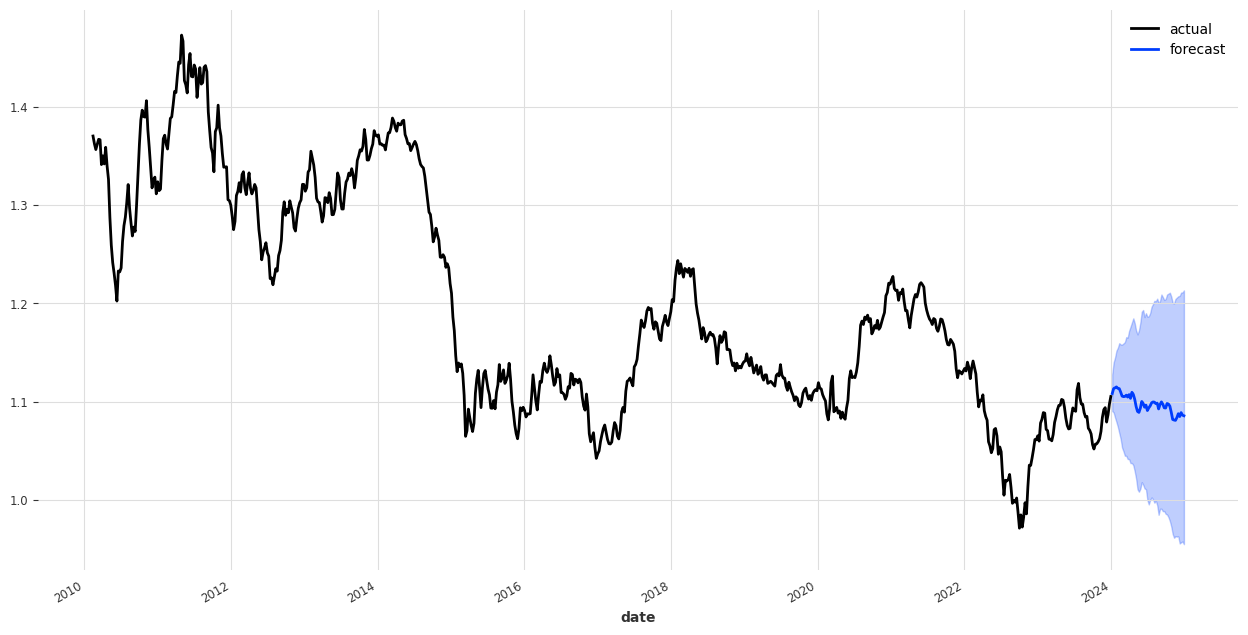

In [36]:
print(("MAPE = {:.2f}%".format(mape(forecast, validation_series))))
# Plot the forecast alongside the actual data
plt.figure(figsize=(15, 7), dpi=100)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax = plt.gca()  # Get the current Axes instance
plt.title("MAPE = {:.2f}%".format(mape(forecast, validation_series)))
training_series.plot(label="actual")
forecast.plot(label="forecast")
plt.legend()

In [37]:
forecast_pdf['forecasted_EUR/USD'] = forecast_pdf.filter(regex='^EUR/USD_s').mean(axis=1)

forecast_pdf['date'] = forecast_pdf.index
forecast_pdf = forecast_pdf.reset_index(drop=True)
forecast_pdf = forecast_pdf[['date', 'forecasted_EUR/USD']]

In [38]:
forecast_pdf.head()

,date,forecasted_EUR/USD
0,2024-01-07,1.108248
1,2024-01-14,1.112948
2,2024-01-21,1.113585
3,2024-01-28,1.115428
4,2024-02-04,1.113320


In [34]:
full_df_extended[['date', 'EUR/USD']].tail()

,date,EUR/USD
Date,,
2024-02-25,2024-02-25,1.08100
2024-03-03,2024-03-03,1.08350
2024-03-10,2024-03-10,1.08998
2024-03-17,2024-03-17,1.09146
2024-03-24,2024-03-24,1.08656


In [39]:
def plot_fx_rate_forecasting(series, forecast, lower_quantile, upper_quantile):
  # Flatten the 'y' data if it's a 2D array with a single column
  series_values_flat = np.ravel(series.values())
  forecast_values_flat = np.ravel(forecast.values())
  lower_quantile_values_flat = np.ravel(lower_quantile.values())
  upper_quantile_values_flat = np.ravel(upper_quantile.values())

  # Plot the forecast alongside the actual data
  plt.figure(figsize=(15, 7), dpi=100)
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  ax = plt.gca()  # Get the current Axes instance

  # Plot actual and forecast series using the flattened 'y' data
  actual_plot, = ax.plot(series.time_index, series_values_flat, label='Actual', color='black')
  forecast_plot, = ax.plot(forecast.time_index, forecast_values_flat, label='Forecast', color='blue')
  lower_quantile_plot, = ax.plot(lower_quantile.time_index, lower_quantile_values_flat, label='5th percentile', color='green')
  upper_quantile_plot, = ax.plot(upper_quantile.time_index, upper_quantile_values_flat, label='95th percentile', color='red')

  # Add vertical dashed lines for important dates
  campaign_start = pd.Timestamp('2023-01-01')
  campaign_end = pd.Timestamp('2023-06-01')
  product_launch = pd.Timestamp('2023-09-01')

  plt.axvline(x=campaign_start, color='magenta', linestyle='--', linewidth=1, label='Campaign Start')
  plt.axvline(x=campaign_end, color='cyan', linestyle='--', linewidth=1, label='Campaign End')
  plt.axvline(x=product_launch, color='green', linestyle='--', linewidth=1, label='Product Launch')

  # Call the methods to get the arrays before indexing
  forecast_time_index = forecast.time_index
  forecast_values = np.ravel(forecast.values())

  # Annotate 'Period Focus' with a vertical arrow
  plt.annotate('Period Focus', xy=(campaign_start, ax.get_ylim()[0]),
  xytext=(0.1, 0.95), textcoords='axes fraction',
  arrowprops=dict(facecolor='purple', arrowstyle='->'), fontsize=9,
  horizontalalignment='left', verticalalignment='top',
  transform=ax.transAxes)

  # Annotate 'Cut-off' with a vertical arrow
  plt.annotate('Cut-off', xy=(campaign_end, ax.get_ylim()[0]),
  xytext=(0.1, 0.9), textcoords='axes fraction',
  arrowprops=dict(facecolor='brown', arrowstyle='->'), fontsize=9,
  horizontalalignment='left', verticalalignment='top',
  transform=ax.transAxes)

  # Set title, labels, and legend
  plt.title('EUR/USD Exchange Rate Forecast with Confidence Intervals')
  plt.xlabel('Date')
  plt.ylabel('Exchange Rate')
  plt.legend(ncol=len(ax.lines), loc='upper center', bbox_to_anchor=(0.5, -0.1))

  # Improve date formatting on the x-axis
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

  # Rotate date labels for better readability
  plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
  plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

  # Show gridlines
  plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

  plt.show()

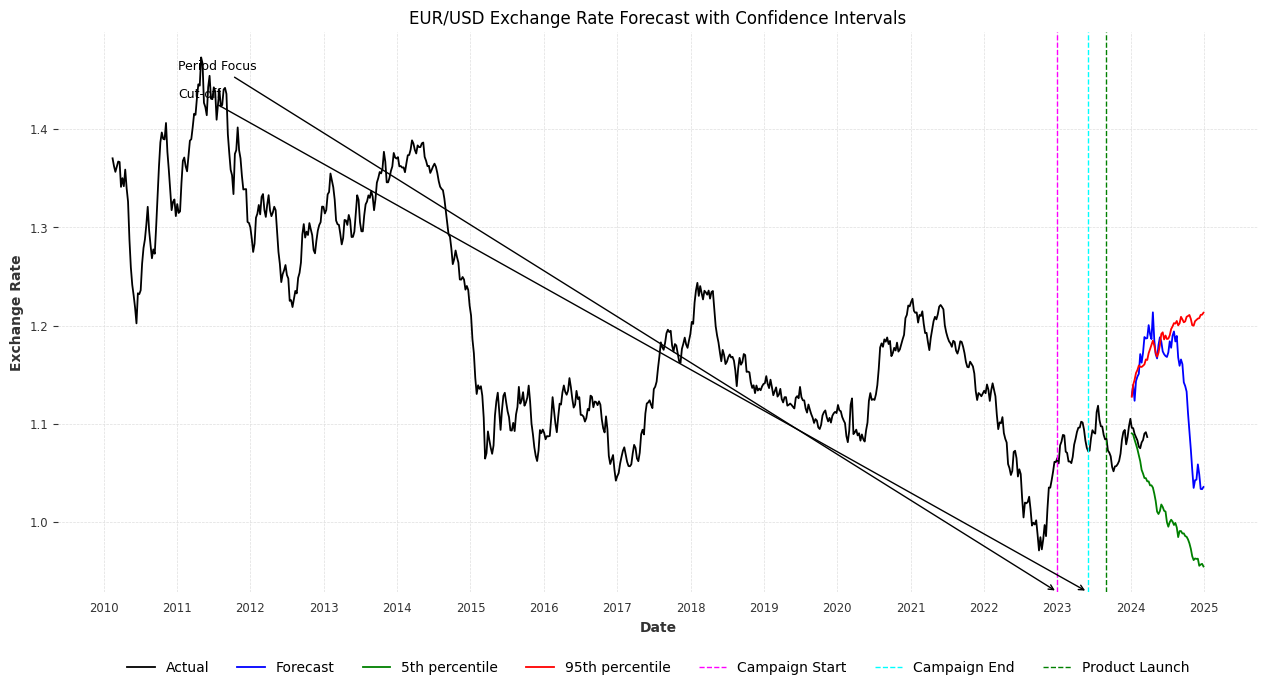

In [40]:
plot_fx_rate_forecasting(series, forecast, lower_quantile, upper_quantile)

In [26]:
# # # Drop any missing values
# # eur_usd.dropna(inplace=True)

# # Check for stationarity
# result = adfuller(eur_usd)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

# # If p-value > 0.05, we need to difference the data to make it stationary
# # if result[1] > 0.05:
# #   eur_usd = eur_usd.diff().dropna()

# # Plot ACF and PACF
# lag_acf = acf(eur_usd, nlags=20)
# lag_pacf = pacf(eur_usd, nlags=20, method='ols')

# # Plot ACF
# plt.figure()
# plt.plot(lag_acf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(eur_usd)), linestyle='--', color='gray')
# plt.axhline(y=1.96/np.sqrt(len(eur_usd)), linestyle='--', color='gray')
# plt.title('Autocorrelation Function')

# # Plot PACF
# plt.figure()
# plt.plot(lag_pacf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(eur_usd)), linestyle='--', color='gray')
# plt.axhline(y=1.96/np.sqrt(len(eur_usd)), linestyle='--', color='gray')
# plt.title('Partial Autocorrelation Function')

# **Forecasting directionality**
Forecasting the directionality of exchange rates (whether they will go up or down) is a common goal in financial time series analysis. One approach is to use classification models that predict whether the change will be positive or negative. Another approach is to look at the sign of the forecasted values from a regression or time series model.

For instance, if we're using a regression model, we can interpret positive predicted values as an indication that the exchange rate is expected to increase, and negative values as a decrease. Similarly, with time series models, we can compare the forecasted value with the last known value to determine the direction of the change.

Here's an example of how we may predict directionality using the sign of the forecasted changes:

In this code snippet, the Direction column is added to the forecast DataFrame, indicating whether the forecasted exchange rate is expected to go up or down compared to the last known rate.

Remember, financial markets are influenced by a multitude of factors, and models can only capture so much. It's important to combine model forecasts with domain expertise and other market analyses. Additionally, the performance of these models should be validated using historical data to assess their predictive power.

In [ ]:
# @title
# Continuing from the ARIMA example above
# Determine the direction of the change
last_known_rate = df['Exchange_Rate'].iloc[-1]
forecast_df['Direction'] = forecast_df['Forecast'].apply(lambda x: 'Up' if x > last_known_rate else 'Down')

print(forecast_df[['Forecast', 'Direction']])